# Exercise:


### 1. Set up early stopping criteria.
### 2. Try different optimizers.
### 3. Modify the network to overfit.
### 4. Apply regularization.
### 5. Apply data augmentation.


### Import relevant packages

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchsummary import summary


### Download training data from open datasets




In [ ]:
# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
val_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 170498071/170498071 [00:03<00:00, 49176686.84it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Check some of the properties of the data set

In [ ]:
classes = training_data.classes
print(classes)

num_training_samples = len(training_data)
print(f"Number of samples in the training data: {num_training_samples}")

num_test_samples = len(val_data)
print(f"Number of samples in the validation set: {num_test_samples}")


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of samples in the training data: 50000
Number of samples in the validation set: 10000


### Setting up the data sets for training and testing

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


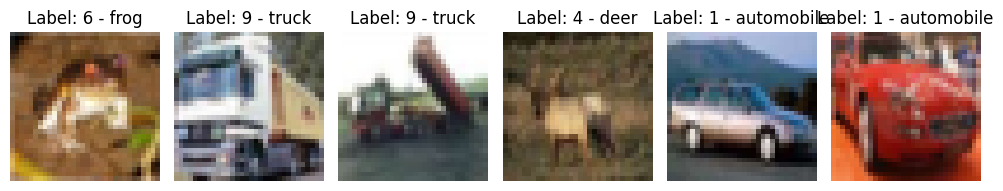

In [ ]:
batch_size = 64 # we will talk about it later

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    fig, axes = plt.subplots(1, 6, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(6):
        img = X[i].squeeze().permute(1,2,0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {y[i]} - {classes[y[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    break

### Defining a simple convolutional network architecture

| Layer type   | size    | Output channels  | Stride |
|--------------|---------|------------------|--------|
| conv         | 5x5     | 6                | 1      |
| relu         |     |                  |       |
| pool         | 2x2     |                  | 2      |
| conv         | 5x5     | 16               | 1      |
| relu         |     |                  |       |
| pool         | 2x2     |                  | 2      |
| fully connected   |      | 256               |       |
| relu         |     |                  |       |
| fully connected   |      | 120               |       |
| relu         |     |                  |       |
| fully connected   |      | 84               |       |
| relu         |     |                  |       |
| fully connected   |      | 10               |       |




In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding='valid')
        self.relu  = nn.ReLU(inplace=True)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear(400, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      return x

model = NeuralNetwork().to(device)
print(model)


Using cuda device
NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### We can also see the model parameters and the size at each layer of the model
This is done by using the pytorchsummary package https://github.com/sksq96/pytorch-summary

In [ ]:
summary(model, input_size=(3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
---------------------------------

### Defining a loss-function

Let’s use a Classification Cross-Entropy loss SGD.
Our labels are one-hot encoded, which means that for each image, we have a target vector with 10 entries (one for each class).
This target vector contains only zeros except for the entry of the class to which the image belongs.

\begin{equation}
H(y,\hat y) = -\sum_j y_j \cdot log(\hat y_j)
\end{equation}

$j \in \{1, 2, \dots, n_{\text{classes}}\}$ and $\hat{y}_j = \begin{cases}
    1 & \text{if } j = \text{true class}, \\
    0 & \text{otherwise}
\end{cases}$

Explanation: Let’s assume a simple case where we have three classes. The true label vector y for a given sample is [0, 0, 1] (indicating class 3 is the correct label), and the model outputs a probability distribution p = [0.1, 0.3, 0.6].

\begin{equation}
\text{Loss} = -[0 \times \log(0.1) + 0 \times \log(0.3) + 1 \times \log(0.6)] = -\log(0.6) = 0.51
\end{equation}



In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Let's use stocastic gradient descent (We will talk about it in the coming weeks)

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")
    return test_loss

In [ ]:
epochs = 100
patience = 5
best_loss = float('inf')
early_stopping_counter = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    current_test_loss = test(val_dataloader, model, loss_fn)

    if current_test_loss < best_loss:
        best_loss = current_test_loss  # Update best loss
        early_stopping_counter = 0  # Reset counter
        print(f"Test loss improved to {best_loss:.6f}, saving model...")
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        early_stopping_counter += 1
        print(f"No improvement in test loss. Early stopping counter: {early_stopping_counter}/{patience}")

    # If the patience counter reaches the patience threshold, stop training
    if early_stopping_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

print("Done!")



Epoch 1
-------------------------------
loss: 2.306193  [   64/50000]
loss: 2.304330  [ 6464/50000]
loss: 2.304324  [12864/50000]
loss: 2.314791  [19264/50000]
loss: 2.296773  [25664/50000]
loss: 2.308642  [32064/50000]
loss: 2.310652  [38464/50000]
loss: 2.302429  [44864/50000]
Train loss: 2.303350, Accuracy: 10.0%
Test Error: 
 Avg loss: 2.303172, Accuracy: 10.0% 

Test loss improved to 2.303172, saving model...
Epoch 2
-------------------------------
loss: 2.305593  [   64/50000]
loss: 2.303903  [ 6464/50000]
loss: 2.303774  [12864/50000]
loss: 2.313459  [19264/50000]
loss: 2.297049  [25664/50000]
loss: 2.307679  [32064/50000]
loss: 2.309657  [38464/50000]
loss: 2.302132  [44864/50000]
Train loss: 2.302943, Accuracy: 10.0%
Test Error: 
 Avg loss: 2.302781, Accuracy: 10.0% 

Test loss improved to 2.302781, saving model...
Epoch 3
-------------------------------
loss: 2.305039  [   64/50000]
loss: 2.303504  [ 6464/50000]
loss: 2.303220  [12864/50000]
loss: 2.312304  [19264/50000]
loss

> making sure that the accuracy is calculated correctly and can be optimized, look up the course description for more details

# Check the performance of the network through train and test loss and accuracy curves

Write your code below to plot the training and test loss and accuracy for each epoch.

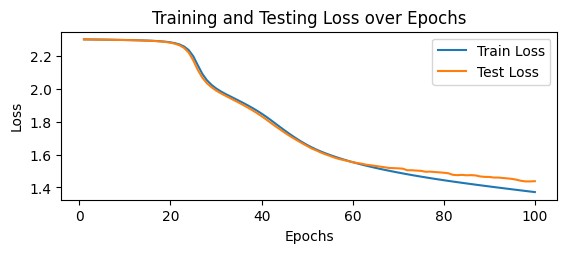

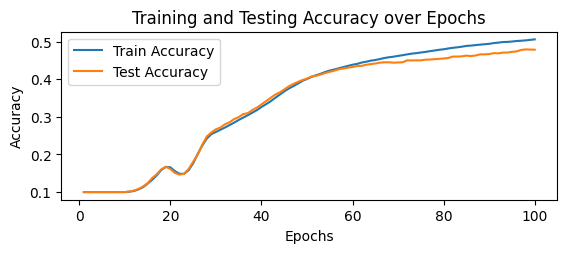

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()


# Check result for one image

Predicted: "cat", Actual: "cat"


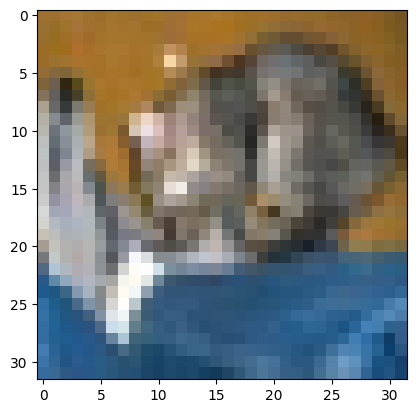

In [ ]:
model.eval()
idx = 0
x, y = val_data[idx][0], val_data[idx][1]
plt.imshow(x.permute(1,2,0))
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


### Another optimizer

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

model_v2 = NeuralNetwork().to(device)
optimizer_v2 = torch.optim.Adam(model_v2.parameters(), lr=1e-3) # Let's use Adam optimizer , keeping all other parameters as default
epochs = 100
patience = 5
best_loss = float('inf')
early_stopping_counter = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_v2, loss_fn, optimizer_v2)
    current_test_loss = test(val_dataloader, model_v2, loss_fn)

    if current_test_loss < best_loss:
        best_loss = current_test_loss  # Update best loss
        early_stopping_counter = 0  # Reset counter
        print(f"Test loss improved to {best_loss:.6f}, saving model...")
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        early_stopping_counter += 1
        print(f"No improvement in test loss. Early stopping counter: {early_stopping_counter}/{patience}")

    # If the patience counter reaches the patience threshold, stop training
    if early_stopping_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

print("Done!")


Epoch 1
-------------------------------
loss: 2.305338  [   64/50000]
loss: 1.990142  [ 6464/50000]
loss: 1.793332  [12864/50000]
loss: 1.714180  [19264/50000]
loss: 1.621977  [25664/50000]
loss: 1.629886  [32064/50000]
loss: 1.746105  [38464/50000]
loss: 1.518818  [44864/50000]
Train loss: 1.730846, Accuracy: 36.5%
Test Error: 
 Avg loss: 1.556946, Accuracy: 42.8% 

Test loss improved to 1.556946, saving model...
Epoch 2
-------------------------------
loss: 1.646558  [   64/50000]
loss: 1.495317  [ 6464/50000]
loss: 1.360124  [12864/50000]
loss: 1.465681  [19264/50000]
loss: 1.393720  [25664/50000]
loss: 1.534498  [32064/50000]
loss: 1.546151  [38464/50000]
loss: 1.384929  [44864/50000]
Train loss: 1.451847, Accuracy: 47.5%
Test Error: 
 Avg loss: 1.386070, Accuracy: 49.8% 

Test loss improved to 1.386070, saving model...
Epoch 3
-------------------------------
loss: 1.466896  [   64/50000]
loss: 1.396248  [ 6464/50000]
loss: 1.127021  [12864/50000]
loss: 1.290657  [19264/50000]
loss

Plotting the loss

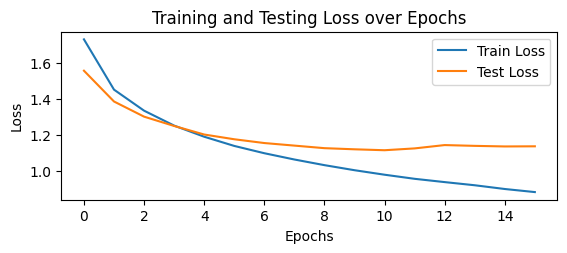

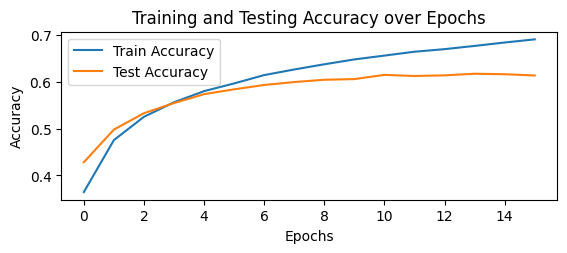

In [ ]:
plt.subplot(2,1,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()



Model to overfit

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=5, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(256, 512, kernel_size=5, padding='valid')
        self.relu  = nn.ReLU(inplace=True)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear(12800, 1280)
        self.fc2   = nn.Linear(1280, 512)
        self.fc3   = nn.Linear(512, 10)

    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      return x

model_v3 = NeuralNetwork().to(device)
#print(model)
summary(model_v3, input_size=(3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]          19,456
              ReLU-2          [-1, 256, 28, 28]               0
         MaxPool2d-3          [-1, 256, 14, 14]               0
            Conv2d-4          [-1, 512, 10, 10]       3,277,312
              ReLU-5          [-1, 512, 10, 10]               0
         MaxPool2d-6            [-1, 512, 5, 5]               0
           Flatten-7                [-1, 12800]               0
            Linear-8                 [-1, 1280]      16,385,280
              ReLU-9                 [-1, 1280]               0
           Linear-10                  [-1, 512]         655,872
             ReLU-11                  [-1, 512]               0
           Linear-12                   [-1, 10]           5,130
Total params: 20,343,050
Trainable params: 20,343,050
Non-trainable params: 0
-------------------------

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

#model_v2 = NeuralNetwork().to(device)
optimizer_v3 = torch.optim.Adam(model_v3.parameters(), lr=1e-3) # Let's use Adam optimizer , keeping all other parameters as default
epochs = 100
patience = 5
best_loss = float('inf')
early_stopping_counter = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_v3, loss_fn, optimizer_v3)
    current_test_loss = test(val_dataloader, model_v3, loss_fn)

    if current_test_loss < best_loss:
        best_loss = current_test_loss  # Update best loss
        early_stopping_counter = 0  # Reset counter
        print(f"Test loss improved to {best_loss:.6f}, saving model...")
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        early_stopping_counter += 1
        print(f"No improvement in test loss. Early stopping counter: {early_stopping_counter}/{patience}")

    # If the patience counter reaches the patience threshold, stop training
    if early_stopping_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

print("Done!")

Epoch 1
-------------------------------
loss: 2.304506  [   64/50000]
loss: 1.817929  [ 6464/50000]
loss: 1.722693  [12864/50000]
loss: 1.550678  [19264/50000]
loss: 1.467779  [25664/50000]
loss: 1.581817  [32064/50000]
loss: 1.508673  [38464/50000]
loss: 1.484607  [44864/50000]
Train loss: 1.600325, Accuracy: 40.7%
Test Error: 
 Avg loss: 1.517100, Accuracy: 46.0% 

Test loss improved to 1.517100, saving model...
Epoch 2
-------------------------------
loss: 1.419417  [   64/50000]
loss: 1.292981  [ 6464/50000]
loss: 1.094281  [12864/50000]
loss: 1.167696  [19264/50000]
loss: 1.379603  [25664/50000]
loss: 1.344219  [32064/50000]
loss: 1.330189  [38464/50000]
loss: 1.250134  [44864/50000]
Train loss: 1.259350, Accuracy: 54.9%
Test Error: 
 Avg loss: 1.249106, Accuracy: 56.1% 

Test loss improved to 1.249106, saving model...
Epoch 3
-------------------------------
loss: 1.245826  [   64/50000]
loss: 1.065035  [ 6464/50000]
loss: 0.862883  [12864/50000]
loss: 1.026424  [19264/50000]
loss

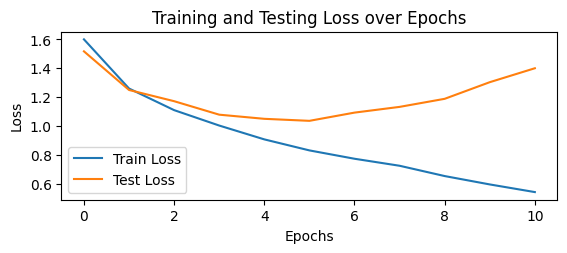

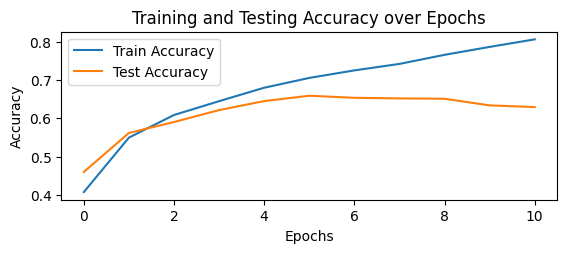

In [ ]:
plt.subplot(2,1,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()

adding L2 regularization

Epoch 1
-------------------------------
loss: 2.308258  [   64/50000]
loss: 1.796856  [ 6464/50000]
loss: 1.500808  [12864/50000]
loss: 1.656941  [19264/50000]
loss: 1.616082  [25664/50000]
loss: 1.636192  [32064/50000]
loss: 1.649297  [38464/50000]
loss: 1.527349  [44864/50000]
Train loss: 1.681130, Accuracy: 36.7%
Test Error: 
 Avg loss: 1.536718, Accuracy: 42.5% 

Test loss improved to 1.536718, saving model...
Epoch 2
-------------------------------
loss: 1.600310  [   64/50000]
loss: 1.427536  [ 6464/50000]
loss: 1.167821  [12864/50000]
loss: 1.500435  [19264/50000]
loss: 1.436420  [25664/50000]
loss: 1.555461  [32064/50000]
loss: 1.539508  [38464/50000]
loss: 1.448701  [44864/50000]
Train loss: 1.435487, Accuracy: 47.3%
Test Error: 
 Avg loss: 1.379442, Accuracy: 49.0% 

Test loss improved to 1.379442, saving model...
Epoch 3
-------------------------------
loss: 1.476987  [   64/50000]
loss: 1.337410  [ 6464/50000]
loss: 1.092030  [12864/50000]
loss: 1.447576  [19264/50000]
loss

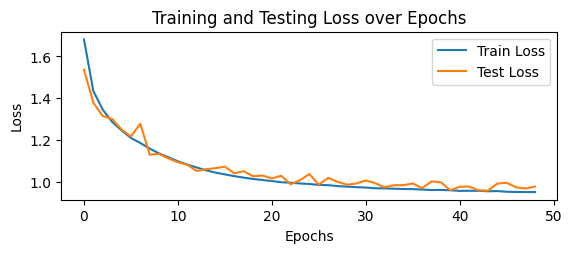

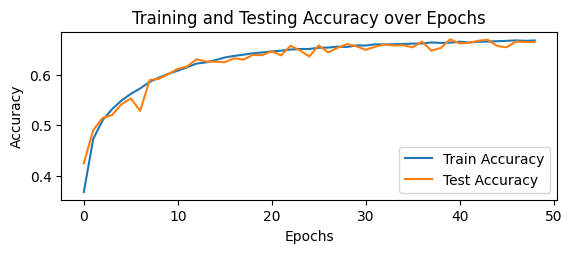

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

model_v4 = NeuralNetwork().to(device)
optimizer_v4 = torch.optim.Adam(model_v4.parameters(), lr=1e-3, weight_decay = 0.01) # Let's use Adam optimizer , keeping all other parameters as default
epochs = 100
patience = 5
best_loss = float('inf')
early_stopping_counter = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_v4, loss_fn, optimizer_v4)
    current_test_loss = test(val_dataloader, model_v4, loss_fn)

    if current_test_loss < best_loss:
        best_loss = current_test_loss  # Update best loss
        early_stopping_counter = 0  # Reset counter
        print(f"Test loss improved to {best_loss:.6f}, saving model...")
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        early_stopping_counter += 1
        print(f"No improvement in test loss. Early stopping counter: {early_stopping_counter}/{patience}")

    # If the patience counter reaches the patience threshold, stop training
    if early_stopping_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

print("Done!")

plt.subplot(2,1,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()